In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install matplotlib
!pip install pylatexenc
!pip install scipy
!pip install -U scikit-learn

!git clone https://github.com/IsaVia777/atelier_qml.git

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_machine_learning.optimizers import COBYLA, SPSA
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, ZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

SEED = 8398

In [3]:
import sys
sys.path.insert(0, '/content/atelier_qml')

from utils import *

# Lab 4: Entraînement d'un classificateur quantique
**Objectifs**
* Bâtir un circuit paramétré
* Classification du jeu de données Iris

In [4]:
x_train,y_train,x_test,y_test = get_iris(SEED)
nb_features = 4
nb_classes = 2

# Assemblage d'un classificateur quantique

## Étape 1:  Circuit quantique paramétré

Le circuit quantique paramétré est composé de deux éléments:

* Un circuit d'encodage des données
* Un circuit pour apprendre la base de mesure

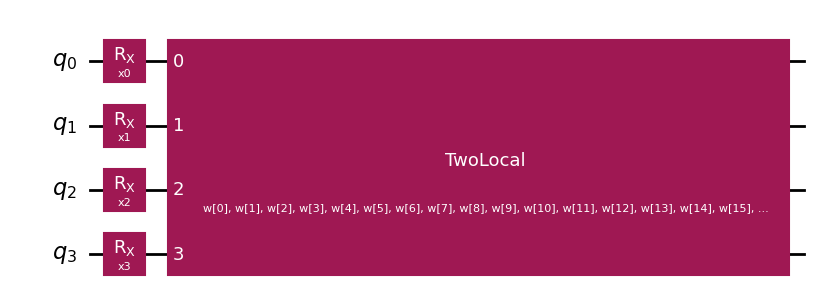

In [5]:
# Circuit d'encodage des données
x_params = [Parameter(f'x{str(i)}') for i in range(nb_features)]
emb_circuit = angle_embedding(x_params, nb_features)

# Circuit pour apprendre la base de mesure
ansatz = TwoLocal(nb_features, ['rz', 'rx'], 'cx', 'linear', reps=2, parameter_prefix='w')

qc = emb_circuit.compose(ansatz)
qc.draw('mpl')

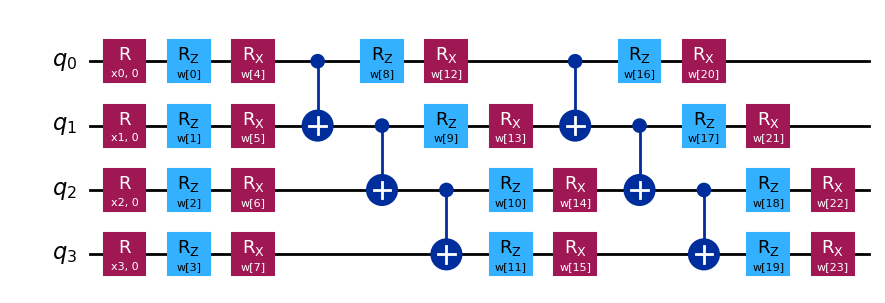

In [6]:
qc.decompose().draw('mpl')

## Circuit QNN

In [7]:
# Initialisation aléatoire des paramètres
np.random.seed(SEED)
initial_weights = np.random.rand(ansatz.num_parameters)

In [8]:
# Fonction d'interprétation de la mesure: la parité compte le nombre
# de "1" dans la chaîne de bits, x,
# et retourne 0 si ce nombre est pair, 1 si impair
def parity(x):
    return '{:b}'.format(x).count('1') % 2

In [9]:
# Initialisation de l'optimiseur
num_iter = 20
optimizer = COBYLA(maxiter=num_iter)

sampler_qnn = SamplerQNN(circuit=qc,
                         input_params=emb_circuit.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=nb_classes)

<ipython-input-9-20082d797698>:5: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(circuit=qc,


In [10]:
# Le vecteur des probabilités d'appartenir à la classe 0 ou 1 pour un point donné
# et une valeur donnée des paramètres s'obtient avec la méthode `CircuitQNN.forward()`
probs = sampler_qnn.forward(x_train[0], initial_weights)
print(f">\n> Probabilité d'appartenir à la classe 0: {probs[0][0]*100:.1f}%\n> Probabilité d'appartenir à la classe 1: {probs[0][1]*100:.1f}%\n>")

>
> Probabilité d'appartenir à la classe 0: 59.4%
> Probabilité d'appartenir à la classe 1: 40.6%
>


## Entraînement du classificateur avec le `NeuralNetworkClassifier`

In [11]:
# Instanciation de la classe utilisée pour entraîner le classificateur quantique
circuit_classifier = NeuralNetworkClassifier(neural_network=sampler_qnn,
                                             optimizer=optimizer,
                                             initial_point=initial_weights)
# Entraînement du model
circuit_classifier.fit(x_train, y_train)

In [12]:
# Calcul de la précision du classificateur sur les ensembles d'entraînement et de test
train_acc = circuit_classifier.score(x_train, y_train)
test_acc = circuit_classifier.score(x_test, y_test)

print(f">\n> Précision sur l'ensemble d'entraînement: {train_acc}\n> Précision sur l'ensemble de test: {test_acc}\n>")

>
> Précision sur l'ensemble d'entraînement: 0.9375
> Précision sur l'ensemble de test: 0.95
>


## Exercice 4

Est-ce qu'on peut faire mieux??<br>
Essayons avec un circuit d'encodage des données plus riche que l'encodage par angle, par exemple `ZZFeatureMap`.

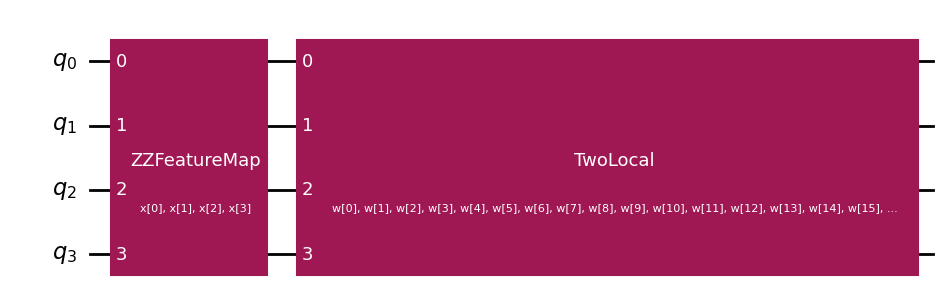

In [16]:
## Votre code ici

# Étape 1 : Définir une carte de caractéristiques plus riche
feature_map = ZZFeatureMap(feature_dimension=nb_features, reps=2, entanglement='linear')

# Étape 2 : Définir l'ansatz
ansatz = TwoLocal(nb_features, ['rz', 'rx'], 'cx', 'linear', reps=2, parameter_prefix='w')

# Composition du circuit complet
qc = feature_map.compose(ansatz)
qc.draw('mpl')  # Visualisation du circuit

In [18]:
## Votre code ici

circuit_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,  # Paramètres d'entrée de la carte de caractéristiques
    weight_params=ansatz.parameters,      # Paramètres de poids
    interpret=parity,
    output_shape=nb_classes
)

<ipython-input-18-4bae4463abc1>:3: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  circuit_qnn = SamplerQNN(


In [19]:
# Instanciation de la classe utilisée pour entraîner le classificateur quantique
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,
                                             optimizer=optimizer,
                                             initial_point=initial_weights)

# Entraînement du model
circuit_classifier.fit(x_train, y_train)

In [20]:
# Calcul de la précision du classificateur sur les ensembles d'entraînement et de test
train_acc = circuit_classifier.score(x_train, y_train)
test_acc = circuit_classifier.score(x_test, y_test)

print(f">\n> Précision sur l'ensemble d'entraînement: {train_acc}\n> Précision sur l'ensemble de test: {test_acc}\n>")

>
> Précision sur l'ensemble d'entraînement: 0.9875
> Précision sur l'ensemble de test: 1.0
>


Pour explorer, vous pouvez faire varier les éléments suivants:
* circuit d'encodage
* optimiseur (nombre d'itération ou encore un autre optimiser, par exemple SPSA)
* fonction d'interprétation de la mesure

In [15]:
# Solution proposée par ChatGPT
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA, SPSA

# Initialisation des constantes et des données
SEED = 8398
np.random.seed(SEED)

# Chargement des données (utilisez la fonction fournie dans le Lab pour charger Iris)
x_train, y_train, x_test, y_test = get_iris(SEED)
nb_features = 4
nb_classes = 2

# Étape 1 : Définir une carte de caractéristiques plus riche
feature_map = ZZFeatureMap(feature_dimension=nb_features, reps=2, entanglement='linear')

# Étape 2 : Définir l'ansatz
ansatz = TwoLocal(nb_features, ['rz', 'rx'], 'cx', 'linear', reps=2, parameter_prefix='w')

# Composition du circuit complet
qc = feature_map.compose(ansatz)
qc.draw('mpl')  # Visualisation du circuit

# Étape 3 : Définir la fonction d'interprétation
def parity(x):
    """Retourne 0 si le nombre de bits à 1 est pair, 1 sinon."""
    return '{:b}'.format(x).count('1') % 2

# Étape 4 : Initialiser les poids et l'optimiseur
initial_weights = np.random.rand(ansatz.num_parameters)
num_iter = 20
optimizer = COBYLA(maxiter=num_iter)  # Vous pouvez remplacer par SPSA(maxiter=num_iter)

# Étape 5 : Configurer le QNN
circuit_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,  # Paramètres d'entrée de la carte de caractéristiques
    weight_params=ansatz.parameters,      # Paramètres de poids
    interpret=parity,
    output_shape=nb_classes
)

# Étape 6 : Instancier et entraîner le classificateur quantique
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn,
    optimizer=optimizer,
    initial_point=initial_weights
)

# Entraîner le modèle
circuit_classifier.fit(x_train, y_train)

# Étape 7 : Évaluer la précision du modèle
train_acc = circuit_classifier.score(x_train, y_train)
test_acc = circuit_classifier.score(x_test, y_test)

print(f">\n> Précision sur l'ensemble d'entraînement: {train_acc:.2f}")
print(f"> Précision sur l'ensemble de test: {test_acc:.2f}")

# Suggestions pour explorer
# - Remplacer ZZFeatureMap par une autre carte de caractéristiques
# - Modifier les paramètres de l'ansatz ou le type d'entanglement
# - Expérimenter avec d'autres optimisateurs (par exemple, SPSA)


<ipython-input-15-e8f9a554cf39>:38: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  circuit_qnn = SamplerQNN(


>
> Précision sur l'ensemble d'entraînement: 0.99
> Précision sur l'ensemble de test: 1.00
